# Homework 5 Problem 4: Digit Classification with Logistic Regression

In this code notebook, we have provided most of the code to perform handwritten digit classification from the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) using a multi-class logistic regression model. We have implemented the logistic regression model, the dataset, and necessary helper functions to partition the dataset and assess model classification accuracy.

In [42]:
import torch
import torch.nn as nn
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class MulticlassLogisticRegression(nn.Module):
    def __init__(self, N, M):
        super().__init__()
        self.N = N # input dimension
        self.M = M # number of classes
        self.weight_matrix = nn.Linear(N, M, bias=True) # N input dimensions, M output dimensions

    def forward(self, x):
        return self.weight_matrix(x)

class MNISTDataset(Dataset):
    def __init__(self):
        mnist_data = torchvision.datasets.MNIST(root='./', download=True, train=True)
        self.images = mnist_data.data # images
        self.labels = mnist_data.targets # digit labels: 0, 1, 2, ..., 9
        self.input_dim = self.images[0].size(0)*self.images[0].size(1) # size of vectorized images
        self.n_classes = 10 # number of digit classes
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(-1).float() # flatten image into vector and convert to floating point
        label = self.labels[idx]
        return image, label

def partition_dataset(dataset, N_examples, p_train, p_val):
    assert (p_train+p_val < 1), 'p_train+p_val must be less than 1!'
    full_dataset_size = len(dataset)
    # sample N_examples indices from dataset
    subset_indices = np.random.choice(np.arange(full_dataset_size), size=N_examples, replace=False)
    # create train, val, test indices
    N_train = int(N_examples*p_train) # number of training examples
    N_val = int(N_examples*p_val) # number of validation examples
    N_test = N_examples - N_train - N_val # remainder used for testing
    train_indices = subset_indices[:N_train]
    val_indices = subset_indices[N_train:N_train+N_val]
    test_indices = subset_indices[N_train+N_val:]
    return train_indices, val_indices, test_indices

def multiclass_model_accuracy(model, input_data, labels):
    predictions = model(input_data)
    predicted_classes = torch.argmax(predictions, dim=1) # find highest scoring class along the columns
    n_correct = torch.sum(torch.eq(predicted_classes, labels)) # check which highest scoring classes match labels
    return n_correct # number of correctly predicted examples

## Visualizing the MNIST Dataset

Below, we instantiate the MNIST dataset class we created above and provide code to visualize example digits from the dataset. Note that these images are $28\times 28$, but we vectorize the images into a length-784 vector for our logistic regression model. Thus, when visualizing images, we reshape the images from the dataset back to $28\times 28$.

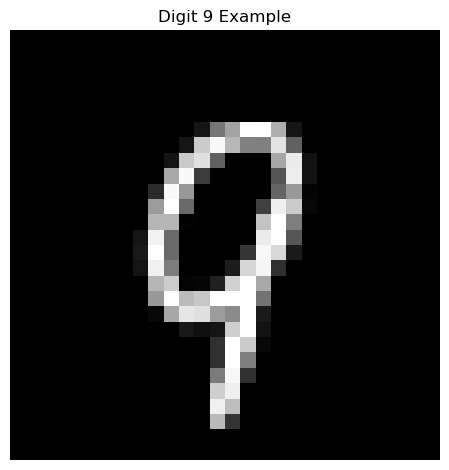

In [43]:
# create dataset and visualize some examples
dataset = MNISTDataset()
idx = 364 # change this to see other dataset examples
plt.figure()
image, label = dataset[idx]
plt.imshow(image.numpy().reshape(28, 28), 'gray')
plt.title('Digit {} Example'.format(label))
plt.axis(False)
plt.tight_layout()

## Training loop

We provide most of the necessary training codes below to fit a multiclass logistic regression with 1000 (image, label) pairs in the dataset where 50% of data is used for training, 30% for validation, and 20% for testing. We do not set the learning rate, momentum parameter, weight decay, or number of epochs (passes through the training dataset). **The following problem parts correspond to the parts asked in Problem 4 of this homework**

## Problem 4: Part (a)

a) Determine reasonable choices for the (i) learning rate, (ii) momentum parameter, (iii) weight decay, and (iv) number of training epochs to train this multiclass logistic regression model. A reasonable choice should lead to training accuracy that is close to 100% (value between 0.9-1.0 for training accuracy below) and remains fairly stable towards the end of training. **Please provide your choices of learning rate, momentum parameter, weight decay, and number of training epochs. Please also provide the resulting loss and accuracy plots generated below and some reasoning or explanation for how you chose these parameters or what choices did not work well.**

Text(0.5, 0, 'Epoch')

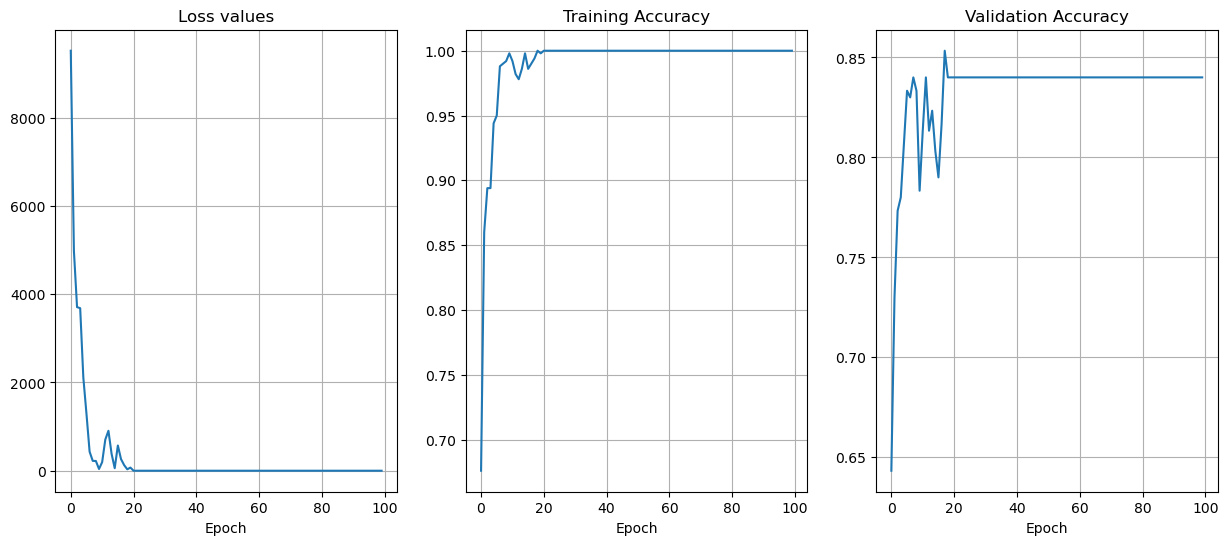

In [44]:
# instantiate multiclass logistic regression model
N = dataset.input_dim
M = dataset.n_classes
model = MulticlassLogisticRegression(N, M)

# partition dataset and create dataloaders
N_examples = 1000
p_train = 0.5
N_train = int(N_examples*p_train)
p_val = 0.3
N_val = int(N_examples*p_val)
batch_size = 8
train_indices, val_indices, test_indices = partition_dataset(dataset, N_examples, p_train, p_val)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices))

# loss and optimizer
criterion = nn.CrossEntropyLoss()
lr = 1e-2 # Find a good choice for this parameter!
momentum = 0.9 # Find a good choice for this parameter!
weight_decay = 0.0001  # Find a good choice for this parameter!
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# how long to train
n_epoch = 100 # Find a good choice for this parameter!
# logging
train_losses, train_accs, val_accs = [], [], []
for n in range(n_epoch):
    epoch_loss, epoch_acc = 0, 0
    for images, labels in train_loader:
        # zero gradients
        optimizer.zero_grad()
        # pass inputs to model
        predictions = model(images)
        # compute loss and backpropagate
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        # logging
        epoch_loss += loss.item()
        epoch_acc += multiclass_model_accuracy(model, images, labels)
    train_losses.append(epoch_loss/len(train_loader))
    train_accs.append(epoch_acc/N_train)
    # validation performance
    val_acc = 0
    for images, labels in val_loader:
        # don't compute gradients since we are only evaluating the model
        with torch.no_grad():
            # validation batch accuracy
            val_acc += multiclass_model_accuracy(model, images, labels)
    val_accs.append(val_acc/N_val)

# plotting
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.plot(train_losses)
plt.grid(True)
plt.title('Loss values')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(train_accs)
plt.grid(True)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(val_accs)
plt.grid(True)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')

## Problem 4: Part (b)

We have provided code below to visualize the learned weight vectors for each class.

(b) Choose two classes, i.e. digit numbers, and share the learned weight vector image generated below. **Please explain what these weight vectors appear to resemble for their class**. For example, what does the weight vector for class 2 look like with respect to how we expects handwritten 2 digits to look like?

(-0.5, 27.5, 27.5, -0.5)

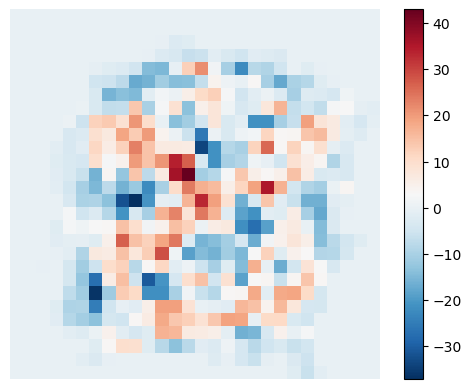

In [45]:
class_idx = 8
# try any of 0, 1, 2, ..., 9 to see which weight vectors are most interesting!
with torch.no_grad():
    A = model.weight_matrix
    features = A.weight[class_idx].detach().numpy().reshape(28, 28)
    bias = A.bias[class_idx].detach().numpy()

plt.figure()
plt.imshow(features, 'RdBu_r')
plt.colorbar()
plt.axis(False)